# brain_Linear_XGboost_Lasso_Ridge_modeling
DC

#### This notebook:
* Load the EWAS aging data selecting for whole blood data and the 2259n ranked cpgs by XGboost importance
* Fit Linear Regression, XGboost, Lasso, and Ridge models predicting age using the top 1000 cpgs
* Test models on Test data
* Save models
* Fit Linear Regression, XGboost, Lasso, and Ridge models predicting age using the top 100 cpgs
* Test models on Test data
* Save models
* Apply blood model, ridge, to brain data

#### Conclusions:
* Best Model Ridge with top 1000 cpgs, MAE = 3.73 on test data
* Other Models not bad
* Blood model does not predict well with brain methylation data


#### Imports

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import os
import pickle
import warnings
warnings.simplefilter('ignore')
plt.rcdefaults()

#### Import our modules

In [24]:
import age_predict.Loading_EWAS_Aging_Data as le
import age_predict.Regression as rg
import age_predict.Pickle_unpickle as pu

In [25]:
# View working directory
os.getcwd()

'/Users/dcox/Desktop/EWAS-organized/brain/modeling'

In [26]:
data_path = '../feature_selection/'
cpg_path = '../saved_features/'
save_models_path = '../saved_models/'
save_blood_model_path = '../../blood/saved_models/'

#### Get Saved imputed brain data 2259 cpgs

In [27]:
df_train = pd.read_csv(data_path + 'df_p_working_brain_ranked.csv', index_col=0)
df_test = pd.read_csv(data_path +  'df_p_saved_brain_ranked.csv', index_col=0)

#### Get Saved brain cpg rankings

In [28]:
cpgs_XGboost_brain_ranked = pu.get_pickled_object(cpg_path + 'cpgs_XGboost_brain_ranked')

In [29]:
top_100 = cpgs_XGboost_brain_ranked[:100]
top_1000 = cpgs_XGboost_brain_ranked[:1000]

#### Histograms of Age

In [30]:
s = pd.Series(list(df_train.age) + list(df_test.age))

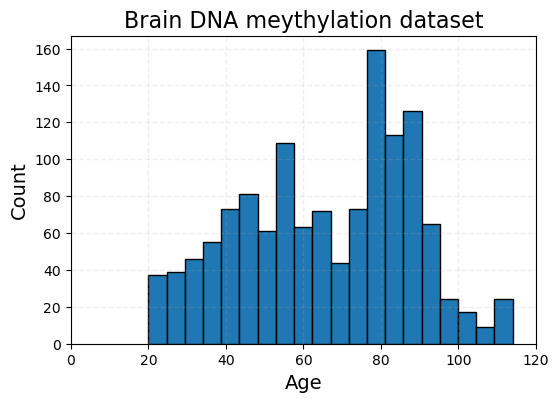

In [31]:
# Histogram of ages in train plus test data
plt.figure(figsize=(6,4))
s.hist(bins=20,histtype='bar', ec='black' )
plt.xlabel('Age', fontsize=14)
plt.xlim(0,120)
plt.ylabel('Count', fontsize=14)
plt.grid(True, lw=1, ls = '--', alpha=0.2)
plt.title('Brain DNA meythylation dataset', fontsize=16)
plt.show()

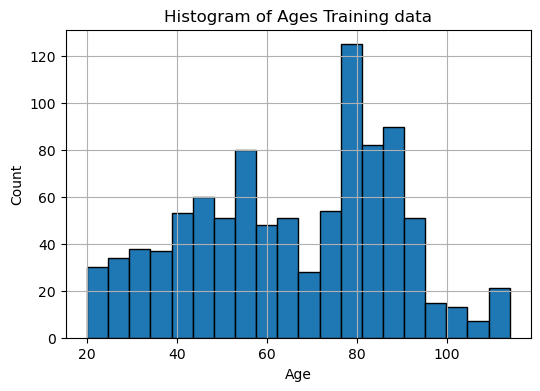

In [32]:
# Histogram of ages in train data
plt.figure(figsize=(6,4))
df_train.age.hist(bins=20, histtype='bar', ec='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Ages Training data')
plt.show()

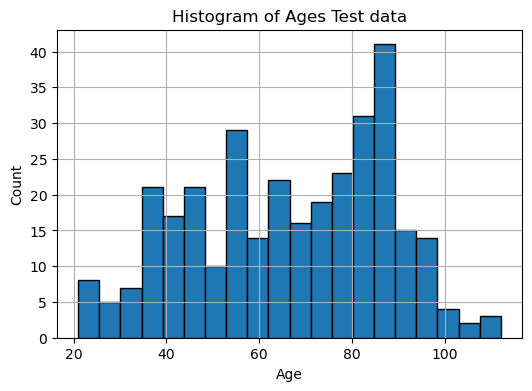

In [33]:
# Histogram of ages in test data
plt.figure(figsize=(6,4))
df_test.age.hist(bins=20,histtype='bar', ec='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Ages Test data')
plt.show()

### Looking at data

In [34]:
df_train

tissue  age  cg18514820  cg21182694  cg09784307  cg01066472  cg02426178  cg12373771  cg16367511  cg24369989  cg23352942  cg04845871  cg11236550  cg15731815  cg17104258  cg18008766  cg24853724  cg11018337  cg15341124  cg15393490  cg14266527  cg27529628  cg21860429  cg06022942  cg03314644  cg26118408  cg00303378  cg01122755  cg07907745  cg03013329  cg17117277  cg19622662  cg02746869  cg14919554  cg11705975  cg26242531  cg06993413  cg23606718  cg13806070  \
GSM2139432  brain - superior temporal gyrus   71       0.075       0.240       0.244       0.331       0.543       0.188       0.217    0.509000       0.475       0.067       0.106       0.139       0.106       0.105       0.090       0.144       0.212       0.226       0.343       0.144       0.132       0.185       0.125       0.059       0.835       0.107       0.235       0.124       0.261       0.088       0.087       0.172       0.391       0.263       0.087       0.158       0.128   
GSM2139249  brain - superior temporal gyrus   76       0.061       0.215       0.269       0.378       0.526       0.165       0.161    0.463000       0.466       0.071       0.087       0.124       0.101       0.130       0.126       0.135       0.254       0.235       0.377       0.151       0.120       0.215       0.172       0.072       0.773       0.100       0.201       0.085       0.291       0.095       0.094       0.163       0.438       0.205       0.123       0.153       0.140   
GSM2139398  brain - superior temporal gyrus  102       0.060       0.219       0.227       0.339       0.480       0.171       0.124    0.523000       0.432       0.039       0.198       0.171       0.188       0.114       0.093       0.122       0.279       0.181       0.376       0.104       0.104       0.156       0.134       0.067       0.797       0.075       0.221       0.097       0.262       0.154       0.091       0.116       0.407       0.224       0.084       0.121       0.067   
GSM2139297  brain - superior temporal gyrus  108       0.147       0.293       0.362       0.528       0.514       0.286       0.261    0.602000       0.559       0.020       0.057       0.189       0.054       0.168       0.146       0.273       0.309       0.147       0.497       0.199       0.185       0.325       0.226       0.088       0.860       0.222       0.322       0.132       0.319       0.053       0.149       0.228       0.454       0.173       0.137       0.262       0.153   
GSM1069208  brain - superior temporal gyrus   40       0.061       0.193       0.195       0.452       0.621       0.124       0.083    0.441000       0.602       0.032       0.314       0.057       0.250       0.073       0.072       0.106       0.188       0.271       0.282       0.125       0.093       0.134       0.054       0.025       0.706       0.059       0.193       0.029       0.143       0.232       0.083       0.111       0.303       0.264       0.065       0.085       0.056   
...                                     ...  ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...   
GSM1573032           brain - occipital lobe   53       0.077       0.201       0.122       0.498       0.544       0.101       0.094    0.443000       0.740       0.028       0.168       0.073       0.216       0.054       0.073       0.137       0.217       0.218       0.306       0.148       0.075       0.183       0.073       0.047       0.821       0.054       0.201       0.043       0.227       0.194       0.128       0.151       0.259       0.167       0.071       0.151       0.127   
GSM1438255           brain - occipital lobe   53       0.080       0.

In [35]:
df_test

tissue  age  cg18514820  cg21182694  cg09784307  cg01066472  cg02426178  cg12373771  cg16367511  cg24369989  cg23352942  cg04845871  cg11236550  cg15731815  cg17104258  cg18008766  cg24853724  cg11018337  cg15341124  cg15393490  cg14266527  cg27529628  cg21860429  cg06022942  cg03314644  cg26118408  cg00303378  cg01122755  cg07907745  cg03013329  cg17117277  cg19622662  cg02746869  cg14919554  cg11705975  cg26242531  cg06993413  cg23606718  \
GSM1443263                  brain - frontal cortex   81       0.076       0.344       0.282       0.416       0.538       0.182    0.182000       0.486       0.534       0.046       0.127       0.193       0.047       0.140       0.114       0.143       0.261       0.214       0.427       0.168       0.127       0.251       0.203       0.091       0.718       0.160       0.242     0.17600       0.279       0.083       0.103       0.155       0.477       0.081       0.123       0.233   
GSM1438273                  brain - occipital lobe   65       0.161       0.172       0.110       0.364       0.592       0.110    0.134000       0.395       0.593       0.074       0.288       0.046       0.303       0.044       0.021       0.125       0.185       0.232       0.352       0.120       0.071       0.171       0.057       0.044       0.865       0.071       0.172     0.06100       0.171       0.297       0.106       0.138       0.332       0.211       0.063       0.153   
GSM1069394                    brain - frontal lobe   79       0.096       0.249       0.288       0.248       0.489       0.246    0.169000       0.596       0.517       0.037       0.065       0.164       0.050       0.179       0.108       0.140       0.269       0.205       0.434       0.202       0.103       0.198       0.173       0.093       0.788       0.121       0.222     0.06500       0.244       0.052       0.073       0.182       0.440       0.245       0.135       0.218   
GSM1069008                    brain - frontal lobe   85       0.108       0.294       0.261       0.574       0.506       0.228    0.180000       0.546       0.479       0.058       0.064       0.152       0.086       0.132       0.104       0.182       0.280       0.234       0.427       0.175       0.177       0.217       0.197       0.074       0.892       0.139       0.237     0.11200       0.278       0.065       0.125       0.188       0.411       0.100       0.100       0.184   
GSM1069068               brain - entorhinal cortex   87       0.119       0.230       0.314       0.399       0.523       0.256    0.188000       0.528       0.566       0.057       0.175       0.194       0.188       0.153       0.114       0.156       0.312       0.333       0.425       0.129       0.153       0.219       0.102       0.134       0.814       0.195       0.254     0.09500       0.322       0.102       0.118       0.194       0.477       0.185       0.117       0.218   
...                                            ...  ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...         ...   
GSM1871874                    brain - frontal lobe   63       0.082       0.272       0.121       0.547       0.567       0.141    0.136000       0.448       0.578       0.026       0.079       0.086       0.166       0.092       0.075       0.144       0.234       0.162       0.352       0.163       0.101       0.179       0.050       0.079       0.834       0.075       0.223     0.04600       0.262       0.082       0.066       0.164       0.324       0.127       0.075       0.164   
GSM1914175  brain - dorsolateral prefrontal cortex   57       0.069       0.217       0.238       0.399       0.595 

#### 1000 cpgs, Train models on training data 70/30 split, Linear, Ridge, Lasso and XGboost 

In [37]:
from sklearn.model_selection import train_test_split
X = df_train[top_1000]
y = df_train.age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2021)

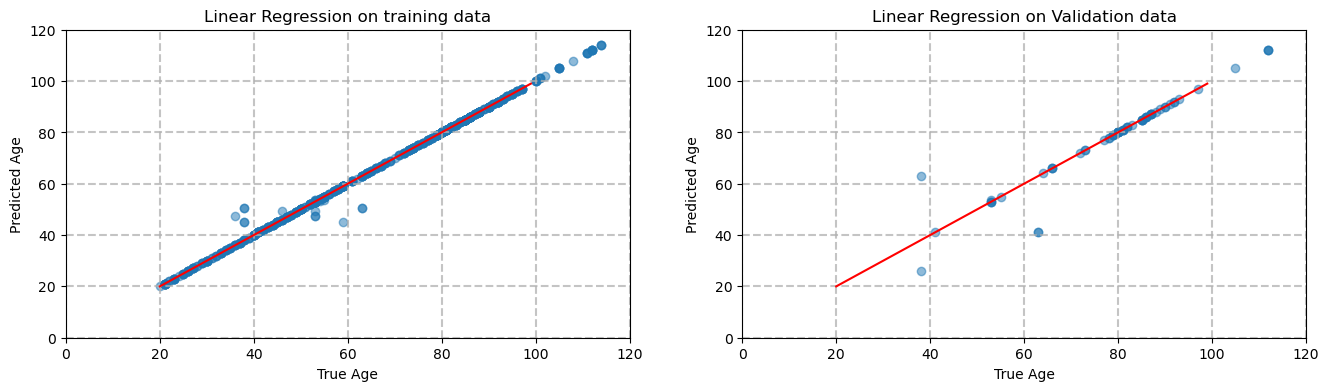

The rms on the training data is 1.297 years
The rms on the validation data is 184955421.002 years
The r^2 on the training data is 0.997
The r^2 on the validation data is -70249139215077.383
The MAe on the training data is 0.165 years
The MAE on the validation data is 124900636.041


In [38]:
brain_mod_1000, rms_train, rms_test, r2_train, r2_test = rg.linear_regress(X_train, y_train, X_test, y_test, plot=True)

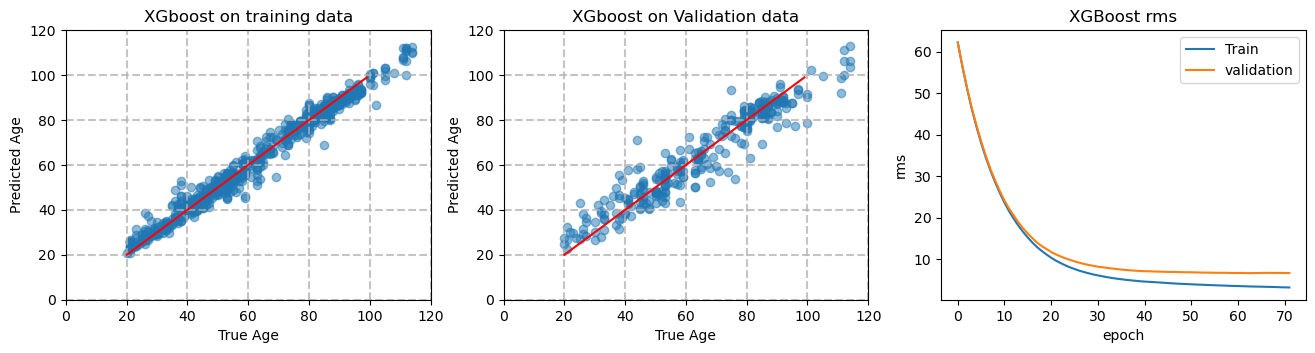

The number of training epochs was 72
The rms on the training data is 3.454 years
The rms on the validation data is 6.640 years
The r^2 on the training data is 0.977
The r^2 on the validation data is 0.909
The MAE on the training data is 2.499 years
The MAE on the validation data is 4.944 years


In [39]:
brain_mod_XG_1000, rms_train, rms_test, r2_train, r2_test, feature_importances_ = rg.xgboost_regress(X_train, y_train, X_test, y_test, early_stopping_rounds=10)

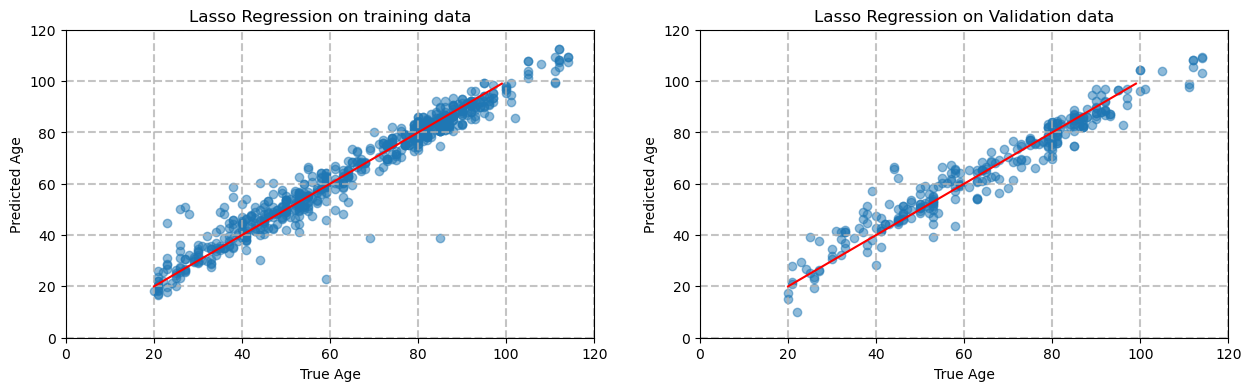

The rms on the training data is 5.201 years
The rms on the validation data is 5.553 years
The r^2 on the training data is 0.947
The r^2 on the validation data is 0.937
The MAE on the training data is 3.431 years
The MAE on the validation data is 4.098 years
Optimal alpha from CV = 0.01


In [40]:
brain_mod_lasso_1000, rms_train, rms_test, r2_train, r2_test = rg.lassoCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5)

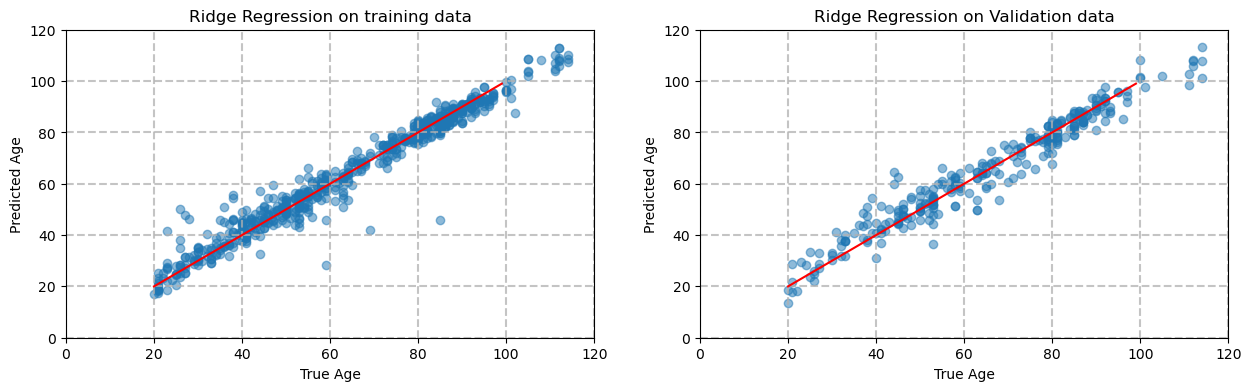

The rms on the training data is 4.481 years
The rms on the validation data is 5.062 years
The r^2 on the training data is 0.961
The r^2 on the validation data is 0.947
The MAE on the training data is 2.915 years
The MAE on the validation data is 3.694 years
Optimal alpha from CV = 1.0


In [41]:
brain_mod_ridge_1000, rms_train, rms_test, r2_train, r2_test = rg.ridgeCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5)

### Saving models

In [42]:
# Save models
# pu.pickle_object(brain_mod_1000, save_models_path + 'brain_mod_1000')
# pu.pickle_object(brain_mod_ridge_1000, save_models_path + 'brain_mod_ridge_1000')
# pu.pickle_object(brain_mod_lasso_1000, save_models_path + 'brain_mod_lasso_1000')
# pu.pickle_object(brain_mod_XG_1000, save_models_path + 'brain_mod_XG_1000')

#### 1000 top cpgs, Testing models on held out test data

In [43]:
X_test = df_test[top_1000]
y_test = df_test.age

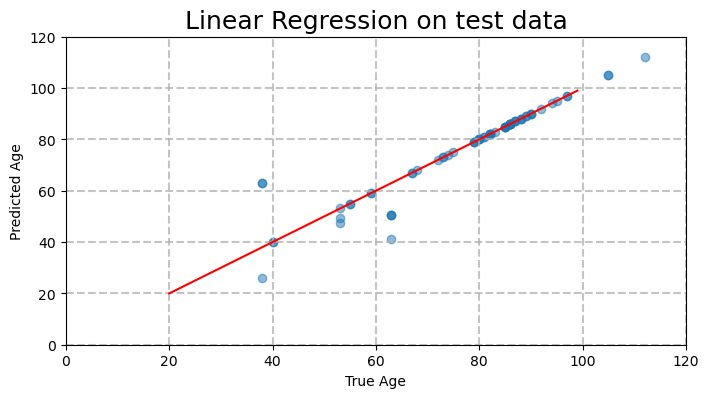

The MSE on Test data is 37202109303536992.000 years
The rms on Test data is 192878483.257 years
The r^2 on Test data is -84914019719045.234
The mae on Test data is 134972530.954 years
The correlation on the Test data true-predicted is -0.034


In [44]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test, y_test, brain_mod_1000, mtype='Linear Regression', figsize=(8,4))

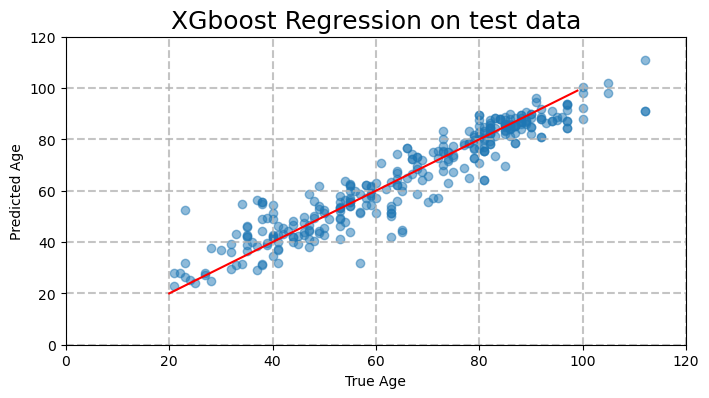

The MSE on Test data is 48.766 years
The rms on Test data is 6.983 years
The r^2 on Test data is 0.889
The mae on Test data is 5.077 years
The correlation on the Test data true-predicted is 0.943


In [45]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test, y_test, brain_mod_XG_1000, mtype='XGboost Regression', figsize=(8,4))

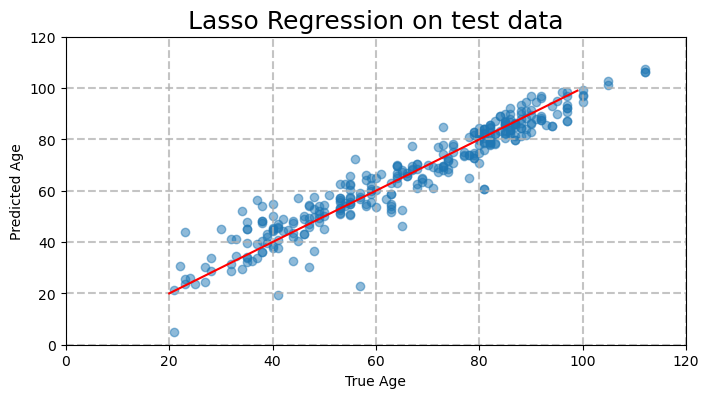

The MSE on Test data is 38.682 years
The rms on Test data is 6.220 years
The r^2 on Test data is 0.912
The mae on Test data is 4.483 years
The correlation on the Test data true-predicted is 0.955


In [46]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test, y_test, brain_mod_lasso_1000, mtype='Lasso Regression', figsize=(8,4))

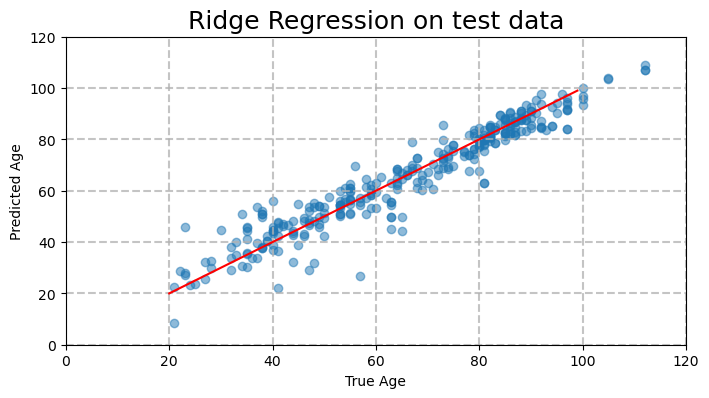

The MSE on Test data is 37.436 years
The rms on Test data is 6.119 years
The r^2 on Test data is 0.915
The mae on Test data is 4.306 years
The correlation on the Test data true-predicted is 0.956


In [47]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test, y_test, brain_mod_ridge_1000, mtype='Ridge Regression', figsize=(8,4))

#### 100 cpgs, Train models on training data 70/30 split, Linear, Ridge, Lasso and XGboost 

In [62]:
from sklearn.model_selection import train_test_split
X = df_train[top_100]
y = df_train.age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2021)

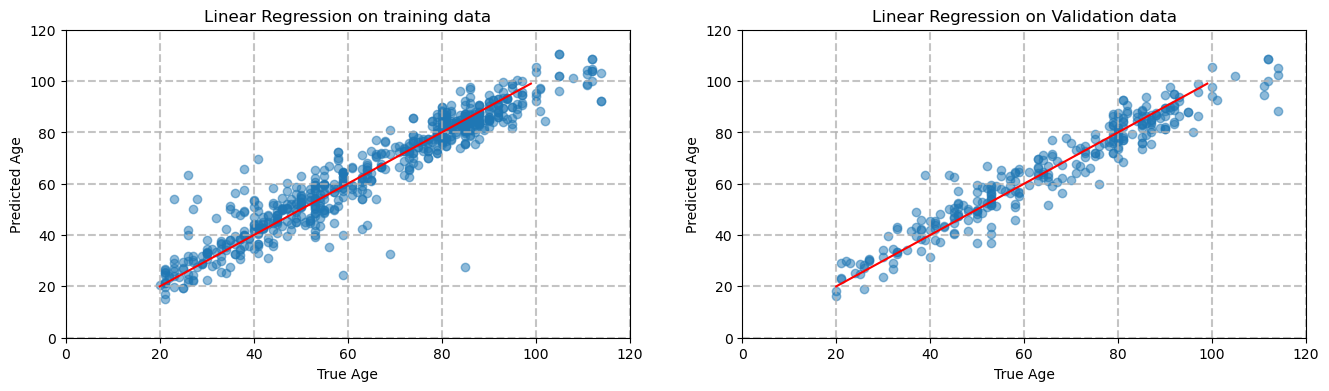

The rms on the training data is 7.005 years
The rms on the validation data is 6.243 years
The r^2 on the training data is 0.905
The r^2 on the validation data is 0.920
The MAe on the training data is 4.765 years
The MAE on the validation data is 4.774


In [49]:
brain_mod_100, rms_train, rms_test, r2_train, r2_test = rg.linear_regress(X_train, y_train, X_test, y_test, plot=True)

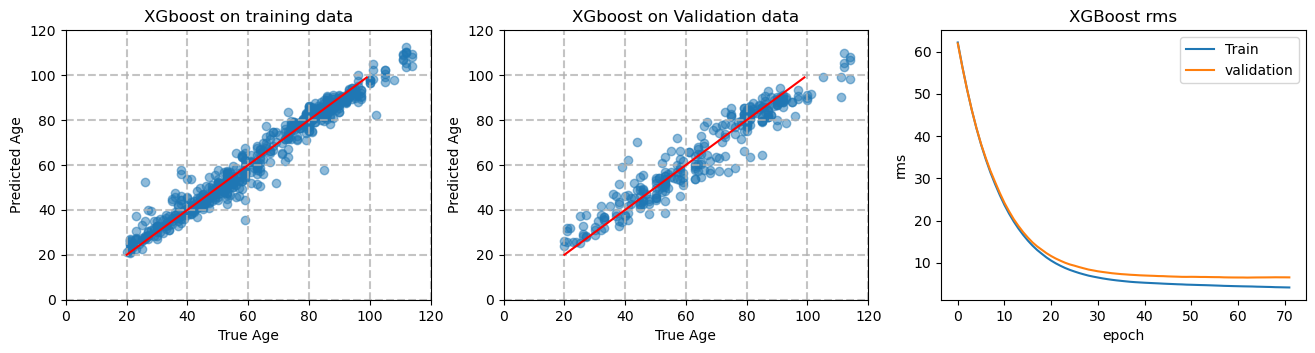

The number of training epochs was 72
The rms on the training data is 4.391 years
The rms on the validation data is 6.482 years
The r^2 on the training data is 0.963
The r^2 on the validation data is 0.914
The MAE on the training data is 3.077 years
The MAE on the validation data is 4.892 years


In [50]:
brain_mod_XG_100, rms_train, rms_test, r2_train, r2_test, feature_importances_ = rg.xgboost_regress(X_train, y_train, X_test, y_test, early_stopping_rounds=10)

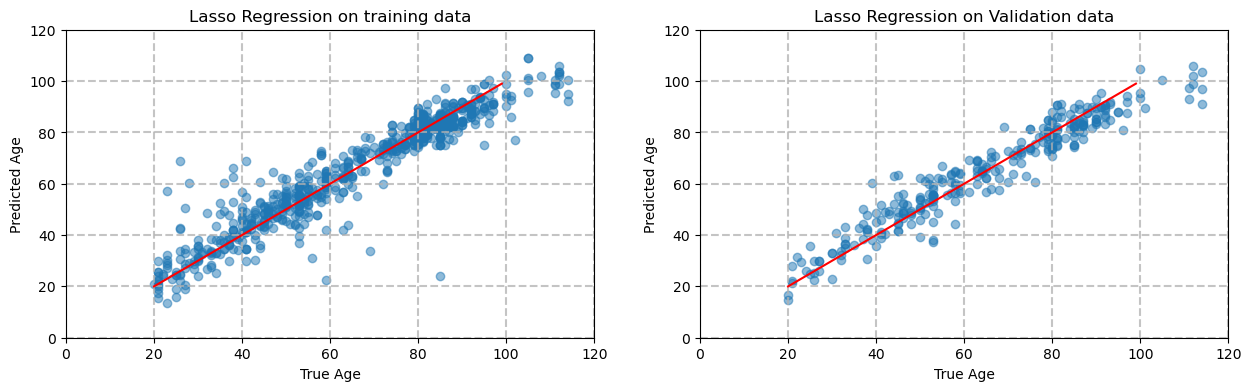

The rms on the training data is 7.357 years
The rms on the validation data is 6.251 years
The r^2 on the training data is 0.895
The r^2 on the validation data is 0.920
The MAE on the training data is 4.842 years
The MAE on the validation data is 4.769 years
Optimal alpha from CV = 0.01


In [51]:
brain_mod_lasso_100, rms_train, rms_test, r2_train, r2_test = rg.lassoCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5)

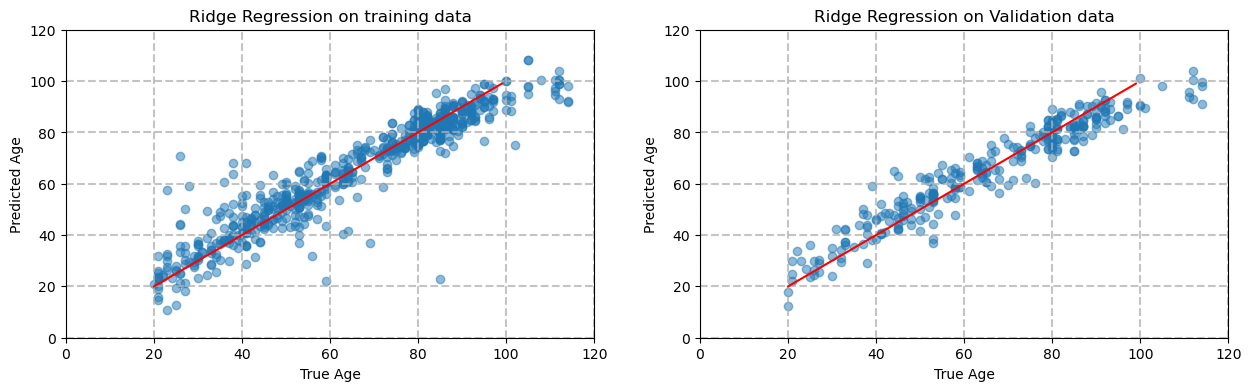

The rms on the training data is 7.528 years
The rms on the validation data is 6.482 years
The r^2 on the training data is 0.890
The r^2 on the validation data is 0.914
The MAE on the training data is 4.960 years
The MAE on the validation data is 4.968 years
Optimal alpha from CV = 1.0


In [52]:
brain_mod_ridge_100, rms_train, rms_test, r2_train, r2_test = rg.ridgeCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5)

In [53]:
# Save models
pu.pickle_object(brain_mod_100, save_models_path + 'brain_mod_100')
pu.pickle_object(brain_mod_ridge_100, save_models_path + 'brain_mod_ridge_100')
pu.pickle_object(brain_mod_lasso_100, save_models_path + 'brain_mod_lasso_100')
pu.pickle_object(brain_mod_XG_100, save_models_path + 'brain_mod_XG_100')

pickled as ../saved_models/brain_mod_100
pickled as ../saved_models/brain_mod_ridge_100
pickled as ../saved_models/brain_mod_lasso_100
pickled as ../saved_models/brain_mod_XG_100


#### 100 cpgs top cpgs, Testing models on held out test data

In [54]:
X_test = df_test[top_100]
y_test = df_test.age

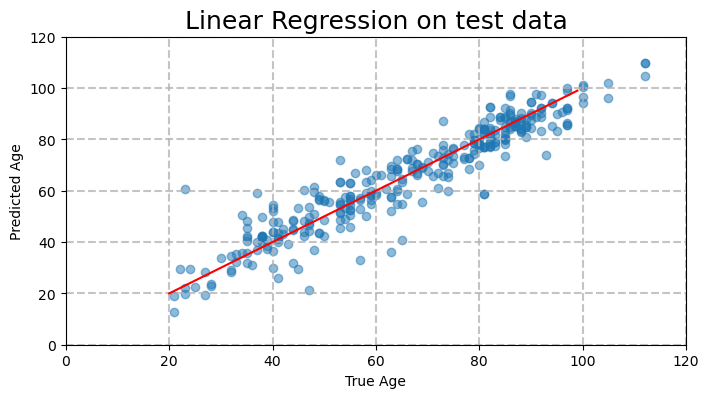

The MSE on Test data is 50.179 years
The rms on Test data is 7.084 years
The r^2 on Test data is 0.885
The mae on Test data is 5.032 years
The correlation on the Test data true-predicted is 0.942


In [55]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test, y_test, brain_mod_100, mtype='Linear Regression', figsize=(8,4))

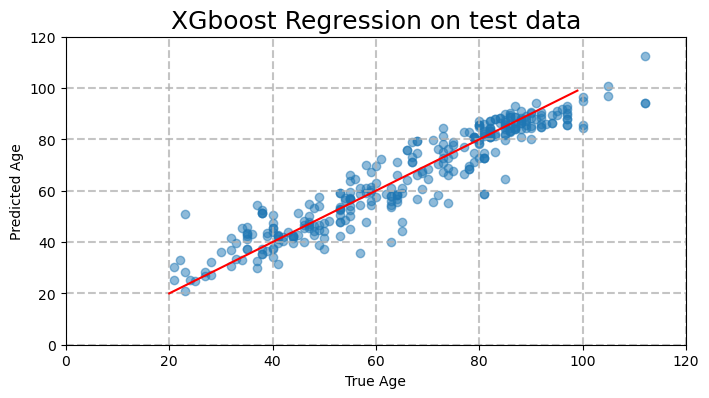

The MSE on Test data is 48.194 years
The rms on Test data is 6.942 years
The r^2 on Test data is 0.890
The mae on Test data is 5.174 years
The correlation on the Test data true-predicted is 0.944


In [56]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test, y_test, brain_mod_XG_100, mtype='XGboost Regression', figsize=(8,4))

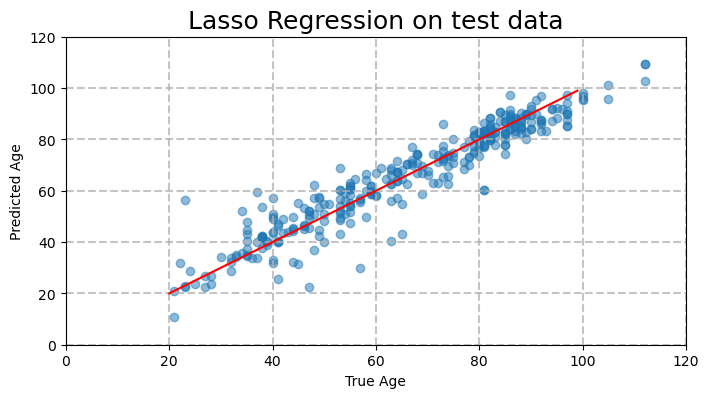

The MSE on Test data is 44.158 years
The rms on Test data is 6.645 years
The r^2 on Test data is 0.899
The mae on Test data is 4.724 years
The correlation on the Test data true-predicted is 0.948


In [57]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test, y_test, brain_mod_lasso_100, mtype='Lasso Regression', figsize=(8,4))

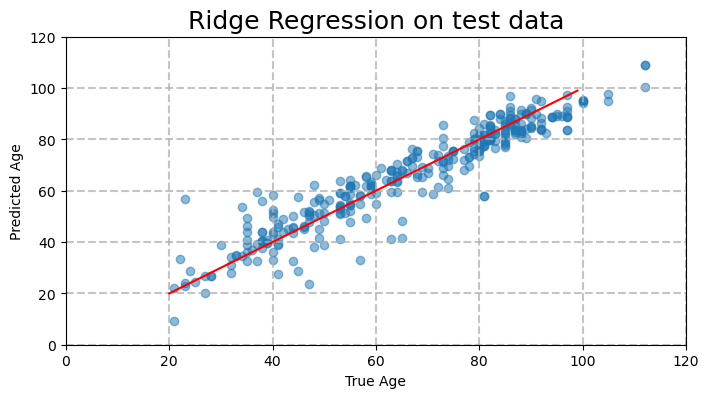

The MSE on Test data is 47.968 years
The rms on Test data is 6.926 years
The r^2 on Test data is 0.891
The mae on Test data is 4.983 years
The correlation on the Test data true-predicted is 0.944


In [58]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test, y_test, brain_mod_ridge_100, mtype='Ridge Regression', figsize=(8,4))

###  Applying blood ridge 1000 model to brain data

In [59]:
X_test = df_test[top_1000]
y_test = df_test.age

In [60]:
wb_mod_ridge_1000 = pu.get_pickled_object(save_blood_model_path + 'wb_mod_ridge_1000')
wb_mod_ridge_100 = pu.get_pickled_object(save_blood_model_path + 'wb_mod_ridge_100')

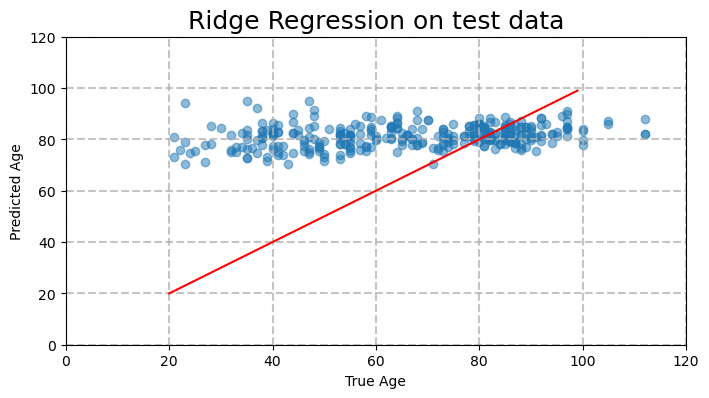

The MSE on Test data is 630.428 years
The rms on Test data is 25.108 years
The r^2 on Test data is -0.439
The mae on Test data is 19.528 years
The correlation on the Test data true-predicted is 0.278


In [61]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test, y_test, wb_mod_ridge_1000, mtype='Ridge Regression', figsize=(8,4))